Setup

In [14]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_id = train_df.id
test_id = test_df.id

Training prep

In [4]:
train_df = train_df.drop(columns=['CustomerId','Surname'])

In [5]:
unique_geographies = train_df['Geography'].unique().tolist()
unique_geographies

['France', 'Spain', 'Germany']

In [6]:
replacement_mapping = {'France': 0, 'Spain': 1, 'Germany': 2}
train_df['Geography'] = train_df['Geography'].replace(replacement_mapping)

In [7]:
gender_mapping = {'Male': 0, 'Female': 1}
train_df['Gender'] = train_df['Gender'].replace(gender_mapping)

In [8]:
train_df

,id,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,668,0,0,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,627,0,0,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,678,0,0,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,581,0,0,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,716,1,0,33.0,5,0.00,2,1.0,1.0,15068.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...
165029,165029,667,1,1,33.0,2,0.00,1,1.0,1.0,131834.75,0
165030,165030,792,0,0,35.0,3,0.00,1,0.0,0.0,131834.45,0
165031,165031,565,0,0,31.0,5,0.00,1,1.0,1.0,127429.56,0
165032,165032,554,1,1,30.0,7,161533.00,1,0.0,1.0,71173.03,0


In [9]:
X = train_df.drop(columns=['id','Exited','CreditScore','Tenure','HasCrCard','EstimatedSalary','Balance'])
y = train_df.Exited
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

In [10]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

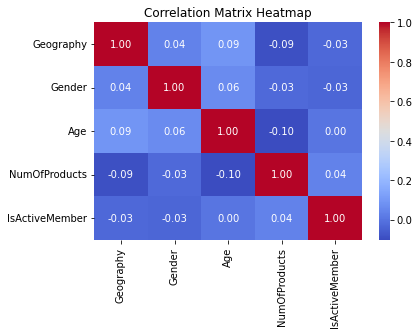

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = X.corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

In [12]:
xgb_model = XGBClassifier()

# Define the parameter grid to search through
param_grid = {
    'learning_rate': [0.1],
    'max_depth': [5],
    'n_estimators': [100],
    'tree_method': ['auto'],
    'validate_parameters': [True],
    'booster': ['gbtree'],
    'colsample_bylevel': [0.9],   
}

# Create a GridSearchCV object with XGBClassifier, the parameter grid, and scoring metric
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate the ROC AUC score on the test set
roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Best Parameters:", best_params)
print("ROC AUC on Test Set:", roc_auc)

Best Parameters: {'booster': 'gbtree', 'colsample_bylevel': 0.9, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'tree_method': 'auto', 'validate_parameters': True}
ROC AUC on Test Set: 0.8768064851754881


In [18]:
!pip install catboost

  Using cached catboost-1.2.2-cp39-cp39-win_amd64.whl (101.0 MB)
  Using cached plotly-5.18.0-py3-none-any.whl (15.6 MB)
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [22]:
import catboost
from catboost import CatBoostClassifier

model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.1, loss_function='Logloss')

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20, verbose=50)

# Make probability predictions on the test set
y_prob = model.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print(f'AUC-ROC: {roc_auc}')

0:	learn: 0.6058476	test: 0.6060494	best: 0.6060494 (0)	total: 15.8ms	remaining: 7.9s
50:	learn: 0.3324735	test: 0.3351060	best: 0.3351060 (50)	total: 611ms	remaining: 5.38s
100:	learn: 0.3316291	test: 0.3347186	best: 0.3347186 (100)	total: 1.19s	remaining: 4.7s
150:	learn: 0.3309002	test: 0.3345860	best: 0.3345860 (150)	total: 1.8s	remaining: 4.17s
200:	learn: 0.3303956	test: 0.3345765	best: 0.3345648 (195)	total: 2.39s	remaining: 3.55s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.3345648349
bestIteration = 195

Shrink model to first 196 iterations.
AUC-ROC: 0.8770155268878196


In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Obtain class probabilities
y_rf = rf_model.predict_proba(X_test)[:, 1]  # Using probabilities for the positive class

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC AUC on Test Set:", roc_auc)

ROC AUC on Test Set: 0.8768064851754881


In [ ]:
test_df = test_df.drop(columns=['CustomerId','id','Surname','CreditScore','Tenure','HasCrCard','EstimatedSalary','Balance'])
replacement_mapping = {'France': 0, 'Spain': 1, 'Germany': 2}
test_df['Geography'] = test_df['Geography'].replace(replacement_mapping)
gender_mapping = {'Male': 0, 'Female': 1}
test_df['Gender'] = test_df['Gender'].replace(gender_mapping)

In [ ]:
test_df

,Geography,Gender,Age,NumOfProducts,IsActiveMember
0,0,1,23.0,2,1.0
1,0,1,46.0,1,0.0
2,0,1,34.0,2,0.0
3,0,0,36.0,1,0.0
4,2,0,38.0,1,0.0
...,...,...,...,...,...
110018,1,0,29.0,1,1.0
110019,0,1,36.0,1,1.0
110020,0,0,31.0,2,0.0
110021,0,1,32.0,1,1.0


In [ ]:
params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'n_estimators': 100,
    'tree_method': 'auto',
    'validate_parameters': True,
    'booster': 'gbtree',
    'colsample_bylevel': 0.9,   
}

model = XGBClassifier(**params)

# Fit the GridSearchCV object to the training data
model.fit(X, y)

y_pred = model.predict_proba(test_df)[:, 1]

In [ ]:
df_pred = pd.DataFrame(y_pred)

In [ ]:
df_pred = pd.concat([test_id, df_pred], axis = 1)

In [ ]:
df_pred = df_pred.rename(columns={0:'Exited'})

In [ ]:
df_pred.to_csv('XGBClassifier5.csv', index=False)

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_model.fit(X, y)

# Obtain class probabilities
y_rf = rf_model.predict_proba(test_df)[:, 1]  # Using probabilities for the positive class

In [ ]:
df2_pred = pd.DataFrame(y_rf)

In [ ]:
df2_pred = pd.concat([test_id, df2_pred], axis = 1)
df2_pred = df2_pred.rename(columns={0:'Exited'})
df2_pred.to_csv('RFClassifier.csv', index=False)